Linear regression with various regularizers 
The UCI Machine Learning dataset repository hosts a dataset giving features of music, and the latitude and longitude from which that music originates here. Investigate methods to predict latitude and longitude from these features, as below. There are actually two versions of this dataset. Either one is OK by me, but I think you'll find the one with more independent variables more interesting. You should ignore outliers (by this I mean you should ignore the whole question; do not try to deal with them). You should regard latitude and longitude as entirely independent.

First, build a straightforward linear regression of latitude (resp. longitude) against features. What is the R-squared? Plot a graph evaluating each regression.

Does a Box-Cox transformation improve the regressions? Notice that the dependent variable has some negative values, which Box-Cox doesn't like. You can deal with this by remembering that these are angles, so you get to choose the origin. why do you say so? For the rest of the exercise, use the transformation if it does improve things, otherwise, use the raw data.

Use glmnet to produce:
A regression regularized by L2 (equivalently, a ridge regression). You should estimate the regularization coefficient that produces the minimum error. Is the regularized regression better than the unregularized regression?
A regression regularized by L1 (equivalently, a lasso regression). You should estimate the regularization coefficient that produces the minimum error. How many variables are used by this regression? Is the regularized regression better than the unregularized regression?

In [17]:
#install.packages(c('dpylr'), repos='http://cran.us.r-project.org', dependencies=TRUE)
library(glmnet)
library(lattice)
library(MASS)
library(broom)
library(dplyr)
library(plotmo)
printf <- function(...) invisible(print(sprintf(...)))

In [18]:
# reads in the data set
wdata = read.csv('music_data_less.txt', header = FALSE)
wdata_org = wdata

# Construct the lat and long fitted datasets.
fit_lat = lm(V69 ~ . - V70, data=wdata)
fit_lon = lm(V70 ~ . - V69, data=wdata)

[1] 0.2900226

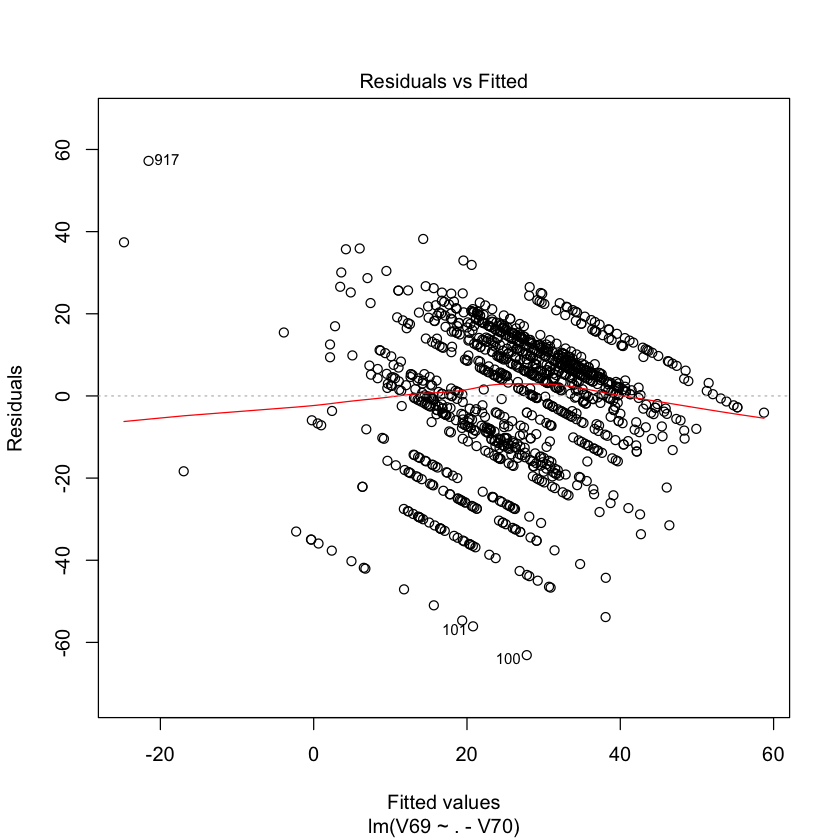

In [19]:
# Plot the residuals vs. the Fitted values for the latitude
plot(fit_lat, which=1)

# Get the value of R^2
summary(fit_lat)$r.squared

[1] 0.3355367

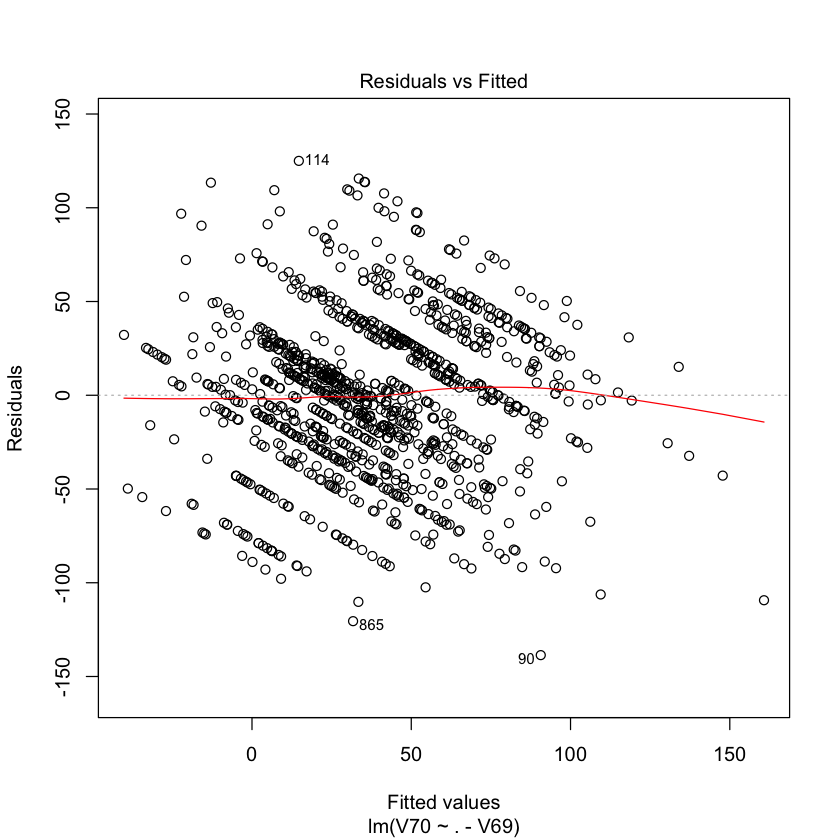

In [20]:
# Plot the residuals vs the fitted values for the longitude
plot(fit_lon, which=1)

# Get the value of R^2
summary(fit_lon)$r.squared

In [30]:
# Now we see the performance of the model when we apply Box-Cox transformations.

# Declare a function that simply adds 90 degrees and apply it to the original dataset.
makePos <- function(y) {
    y - min(y) + 90
}

wdata = mutate_at(wdata, vars(V69, V70), funs(makePos(.)))

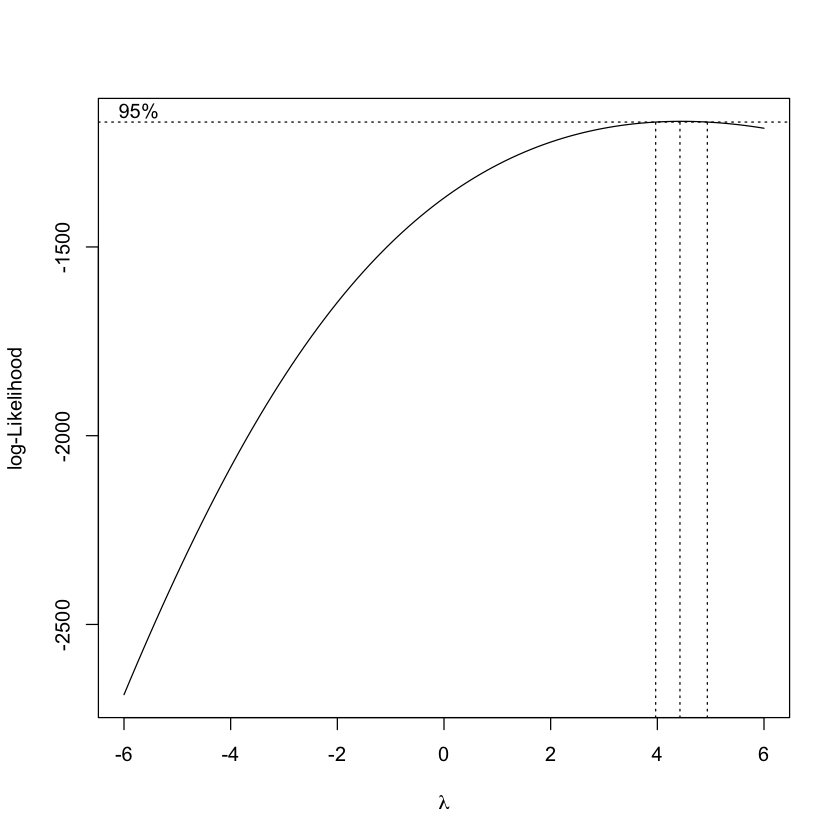

[1] 4.424242
[1] 1.030303


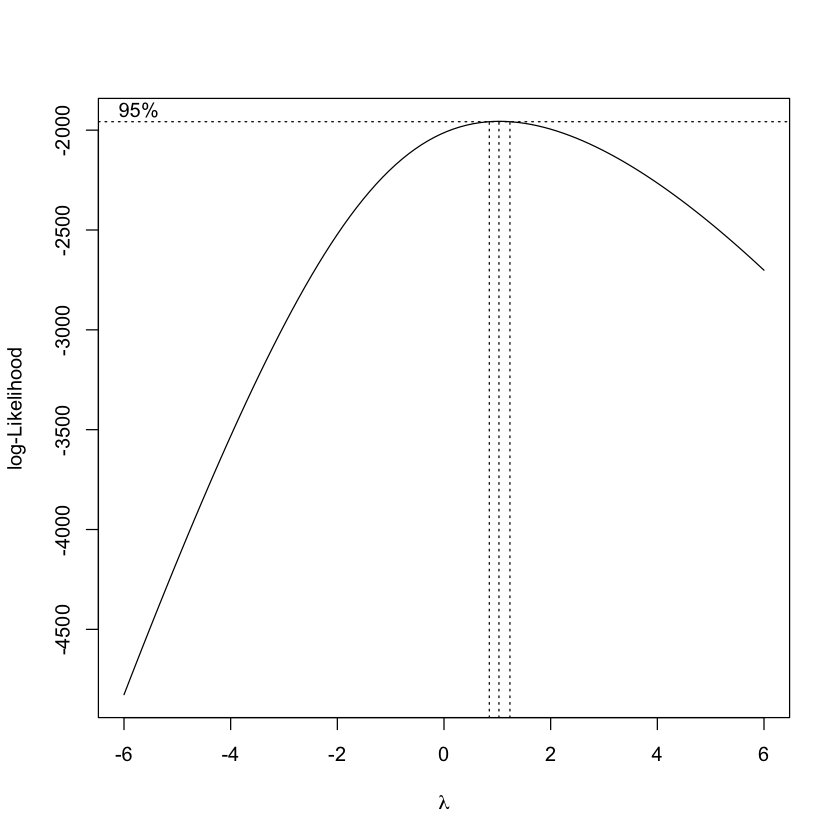

In [32]:
# Apply Box-cox for both latitude and longtitude
lat_box = boxcox(V69 ~ . - V70, data=wdata, lambda = seq(-6, 6, .2))
lon_box = boxcox(V70 ~ . - V69, data=wdata, lambda = seq(-6, 6, .2))

# Calculate the maximum values of lambda.
blat = cbind(lat_box$x, lat_box$y)
blon = cbind(lon_box$x, lon_box$y)

# Grab the values for lambda.
max_lat_lambda = head(blat[order(-lat_box$y)], n=1)
max_lon_lambda = head(blat[order(-lon_box$y)], n=1)
print(max_lat_lambda)
print(max_lon_lambda)

In [29]:
fit_lat = lm(V69^max_lat_lambda ~ . - V70, data=wdata)
fit_lon = lm(V70^max_lon_lambda ~ . - V69, data=wdata)
print(summary(fit_lat))
print(summary(fit_lon))


Call:
lm(formula = V69^max_lat_lambda ~ . - V70, data = wdata)

Residuals:
    Min      1Q  Median      3Q     Max 
-2995.1  -673.4   136.0   699.1  2880.2 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2552.622     31.028  82.268  < 2e-16 ***
V1           462.827    211.737   2.186 0.029059 *  
V2          -505.509    219.578  -2.302 0.021532 *  
V3           -19.361     73.847  -0.262 0.793241    
V4          -358.619     90.237  -3.974 7.57e-05 ***
V5           -34.614     48.307  -0.717 0.473826    
V6           -49.725     58.505  -0.850 0.395567    
V7           -61.222     46.086  -1.328 0.184337    
V8           -32.358     37.266  -0.868 0.385437    
V9           -68.917     44.529  -1.548 0.122012    
V10            9.278     40.615   0.228 0.819359    
V11           -7.419     39.682  -0.187 0.851734    
V12            2.066     37.233   0.055 0.955754    
V13            5.758     36.958   0.156 0.876224    
V14            5.187     38.527 

We see that the performance of the model did not change significantly when applying a Box-Cox transformation. Therefore, for the rest of the excercises we will use the raw dataset to see if there are significant increases in performance when applying L1 and L2 regression. First, we will try to perform a regression regularized by L2. 

In [13]:
wdata_org = na.omit(wdata_org)
X <- as.matrix(wdata_org[, -1])
y_lat <- as.double(as.matrix(wdata_org[, ncol(wdata_org) - 1]))
y_lon <- as.double(as.matrix(wdata_org[, ncol(wdata_org)]))


cv.ridge_lat <- cv.glmnet(X, y_lat, alpha=0)
cv.ridge_lon <- cv.glmnet(X, y_lon, alpha=0)

#Get the lambda values that produced the minimum error.
#Print the values of the best value of lambda.
printf("The best value of lambda for lat: %f", cv.ridge_lat$lambda.min)
printf("The best value of lambda for lon: %f", cv.ridge_lon$lambda.min)

[1] "The best value of lambda for lat: 2.024964"
[1] "The best value of lambda for lon: 5.530952"


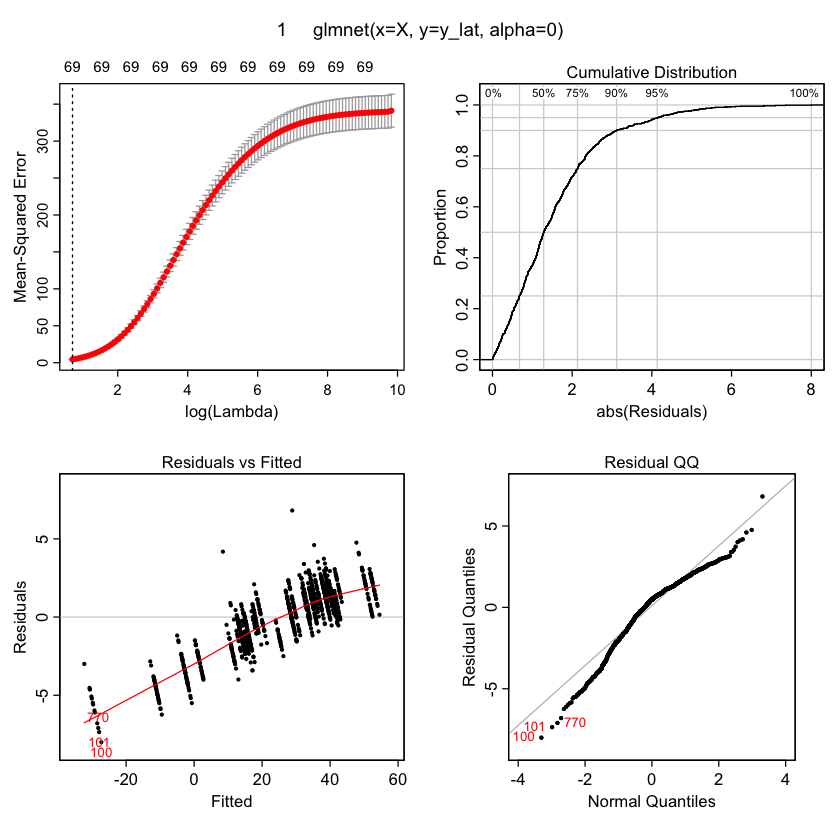

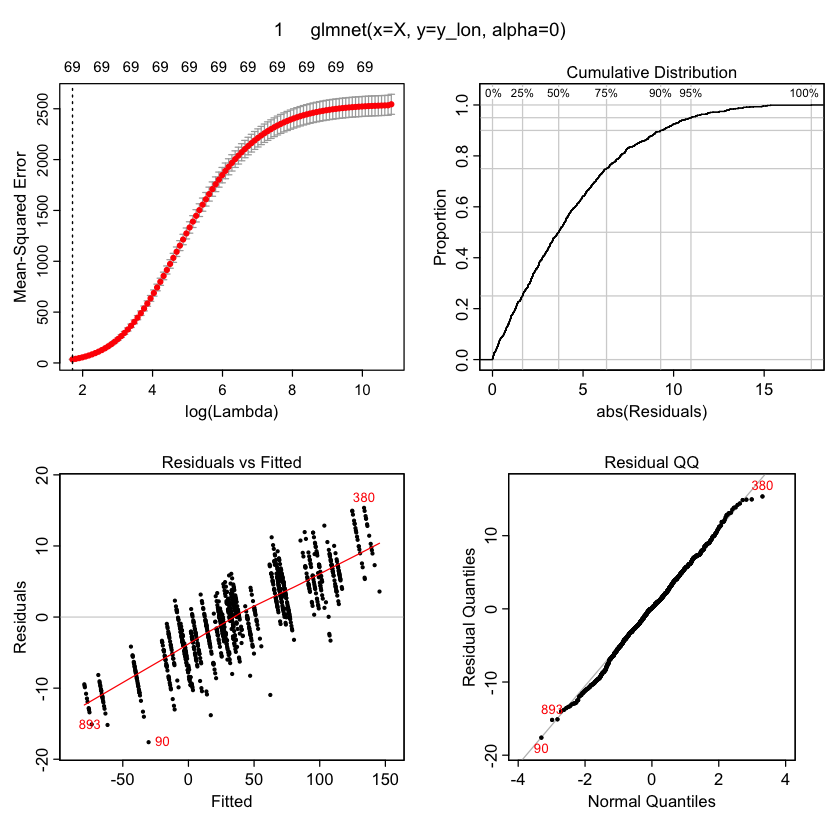

In [9]:
plotres(cv.ridge_lat)
plotres(cv.ridge_lon)

When comparing the Residuals vs. the Fitted values, it is apparent that when comparing the Residuals vs. Fitted values that the regularized regression is in fact better than the unregularized regression.

Now, we perform the same analysis but instead look at a regularization regularized by Lasso Regression.

[1] "The best value of lambda for lat: 0.590288"
[1] "The best value of lambda for lon: 1.612302"


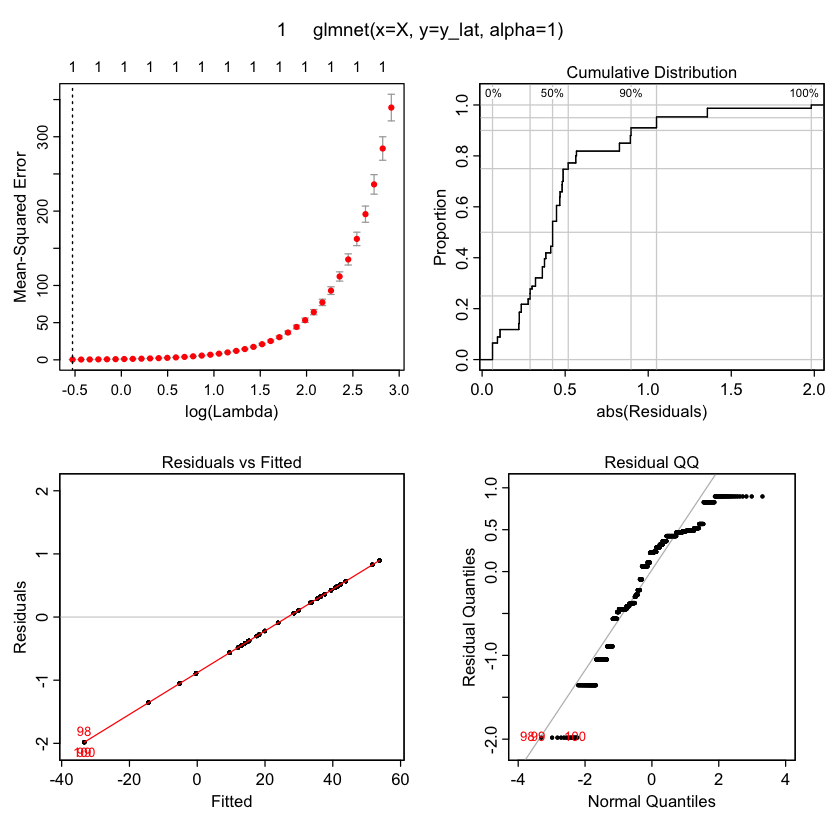

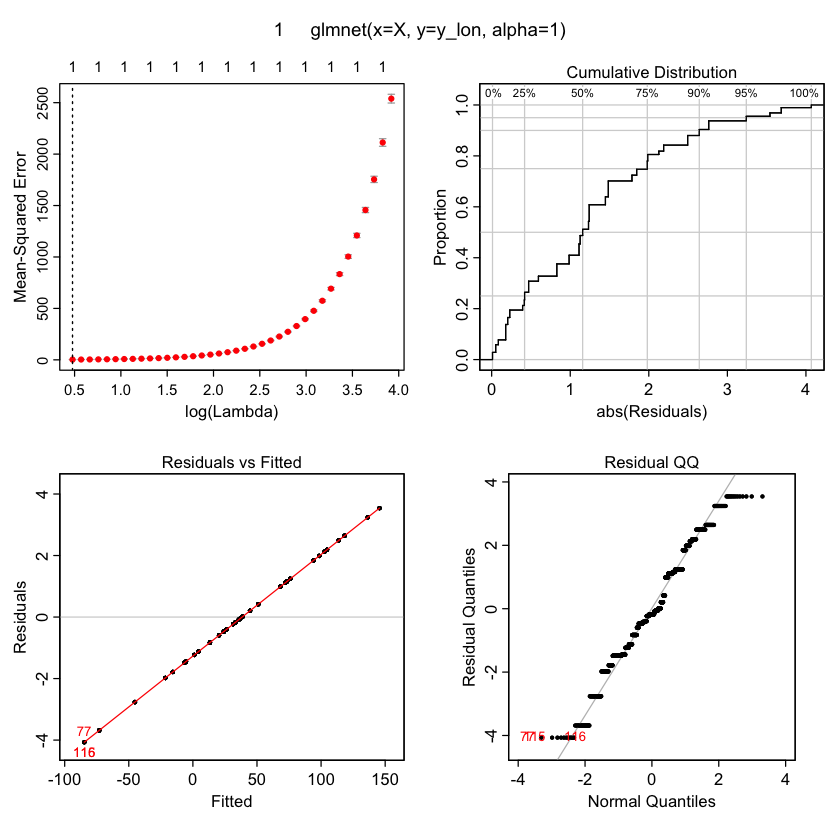

In [14]:
cv.lasso_lat <- cv.glmnet(X, y_lat, alpha=1)
cv.lasso_lon <- cv.glmnet(X, y_lon, alpha=1)

printf("The best value of lambda for lat: %f", cv.lasso_lat$lambda.min)
printf("The best value of lambda for lon: %f", cv.lasso_lon$lambda.min)

plotres(cv.lasso_lat)
plotres(cv.lasso_lon)

Now grab the number of coefficents used by the model


In [16]:
coef(cv.lasso_lat)

70 x 1 sparse Matrix of class "dgCMatrix"
                    1
(Intercept) 0.8526461
V2          .        
V3          .        
V4          .        
V5          .        
V6          .        
V7          .        
V8          .        
V9          .        
V10         .        
V11         .        
V12         .        
V13         .        
V14         .        
V15         .        
V16         .        
V17         .        
V18         .        
V19         .        
V20         .        
V21         .        
V22         .        
V23         .        
V24         .        
V25         .        
V26         .        
V27         .        
V28         .        
V29         .        
V30         .        
V31         .        
V32         .        
V33         .        
V34         .        
V35         .        
V36         .        
V37         .        
V38         .        
V39         .        
V40         .        
V41         .        
V42         .        
V43         